# Fitting the Barnes Gyro relation using a basic fit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import warnings
warnings.filterwarnings('ignore')

For now we'll assume that BPRP and Age have no uncertainty. We'll add the uncertainty on those later with a latent implementation.

$P = \tau^a \times b(B - V - c)^c$

where $P$ is rotation in days
$\tau$ is age (in Myr),
B-V are colour in magnitude,
the rest are free parameters


In [72]:
angus = [0.55, 0.40, 0.45, 0.31]

def gyro(tau, bv, a, b, c, d):
    return (tau*1000)**a * b*(bv - c)**d

In [73]:
npts = 100

bprp_true = np.abs(np.sort(np.random.normal(1., 0.2, npts)))
age_true = np.abs(np.random.normal(5., 3, npts))
period_true = np.abs(gyro(age_true, bprp_true, *angus))

sigma_p = 4.*np.ones(npts)
period_obs = np.abs(period_true + np.random.randn(npts) * sigma_p)

bprp_obs = bprp_true
sigma_bprp = np.zeros(bprp_true.shape)
# sigma_bprp = .05 * np.ones(npts)
# bprp_obs = bprp_true + np.random.randn(npts) * sigma_bprp

# sigma_age = np.random.uniform(.05, .1) * age_true
# age_obs = age_true + np.random.randn(npts) * sigma_age
age_obs = age_true
sigma_age = np.zeros(age_true.shape)

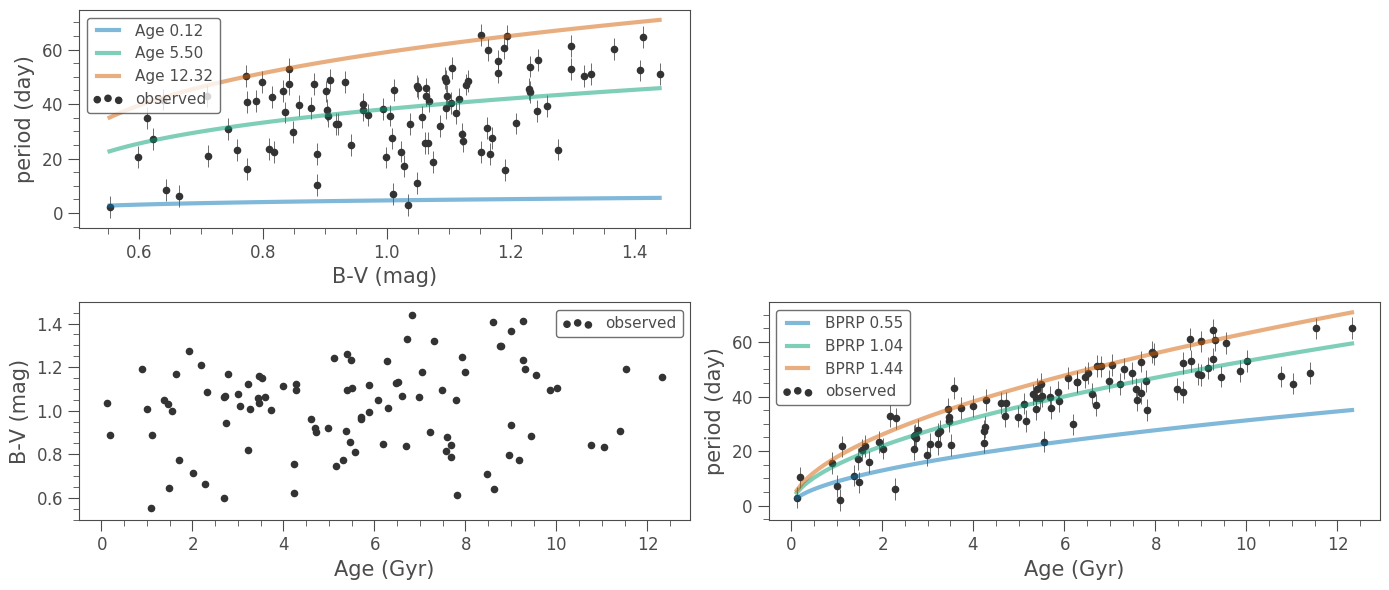

In [74]:
import matplotlib.gridspec as gridspec
import mystyle as ms

with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
#     ax0.plot(bprp_true, period_true, label='Truth')
    ax0.scatter(bprp_obs, period_obs,zorder=1, s=20, label='observed')
    ax0.errorbar(bprp_obs, period_obs, yerr=sigma_p, xerr=sigma_bprp, fmt='|',zorder=0)
    ax0.set_xlabel('B-V (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
#     ax1.plot(age_true, period_true, label='Truth')
    ax1.scatter(age_obs, period_obs,zorder=1, s=20, label='observed')
    ax1.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
#     ax2.plot(age_true, bprp_true, label='Truth')
    ax2.scatter(age_obs, bprp_obs,zorder=1, s=20, label='observed')
    ax2.errorbar(age_obs, bprp_obs, yerr=sigma_bprp, xerr=sigma_age, fmt='|',zorder=0)
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('B-V (mag)')
    ax2.legend()    
    
    agex = np.linspace(age_true.min(), age_true.max(), 100)
    ax1.plot(agex, gyro(agex, bprp_true.min(), *angus), label='BPRP {:.2f}'.format(bprp_true.min()), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, np.mean(bprp_true), *angus), label='BPRP {:.2f}'.format(np.median(bprp_true)), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, bprp_true.max(), *angus), label='BPRP {:.2f}'.format(bprp_true.max()), 
             lw=3, alpha=.5)    
    ax1.legend()
    
    bprpx = np.linspace(bprp_true.min(), bprp_true.max(), 100)
    ax0.plot(bprpx, gyro(age_true.min(), bprpx, *angus), label='Age {:.2f}'.format(age_true.min()), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(np.mean(age_true), bprpx, *angus), label='Age {:.2f}'.format(np.median(age_true)), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(age_true.max(), bprpx, *angus), label='Age {:.2f}'.format(age_true.max()), 
             lw=3, alpha=.5)    
    ax0.legend()    
    
    fig.tight_layout()
    plt.show()

In [33]:
angus = [0.40, 0.31, 0.45, 0.55] 

def gyro(tau, bv, a, b, c, d):
    return tau*1000**d * a*(bv - c)**b

Now lets fit for Period using a latent parameter model

In [82]:
latentfit = '''
data {
    int<lower=1> N;
    real<lower=0> P[N];
    real<lower=0> sigma_p[N];
    
    real bprp[N];
    real<lower=0> age[N];
}
parameters {
    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    real M[N];
    
    for (n in 1:N){
        M[n] = (age[n]*1000)^a * b * (bprp[n] - c)^d;
    }
    
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    c ~ normal(0., 1.);
    d ~ normal(0., 1.);
    
    P ~ normal(M, sigma_p);
}
'''
sm = pystan.StanModel(model_code = latentfit, model_name='latentfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL latentfit_1c0afefae42e7942092ebadf0fc5f629 NOW.


In [88]:
data = {'N' : len(period_obs),
       'P' : period_obs,
       'sigma_p' : sigma_p,
       'bprp' : bprp_obs,
       'age' : age_obs}


init = {'a' : angus[0],
        'b' : angus[1],
        'c' : angus[2],
        'd' : angus[3]}

In [94]:
fit = sm.sampling(data=data, iter=10000, chains=4, seed=11,
                  init = [init for n in range(4)])

In [95]:
print(fit)

Inference for Stan model: latentfit_1c0afefae42e7942092ebadf0fc5f629.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      0.57  3.8e-4   0.02   0.52   0.55   0.57   0.58   0.61   3583    1.0
b      0.33  1.2e-3   0.07   0.22   0.28   0.33   0.38   0.49   3440    1.0
c      0.24  3.1e-3   0.15   0.01   0.12   0.23   0.36   0.52   2280    1.0
d      0.41  2.0e-3   0.09   0.23   0.34   0.41   0.48   0.59   2159    1.0
lp__ -71.02    0.02   1.54  -74.8 -71.83 -70.67 -69.87 -69.05   4056    1.0

Samples were drawn using NUTS at Fri Jul 12 13:50:51 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


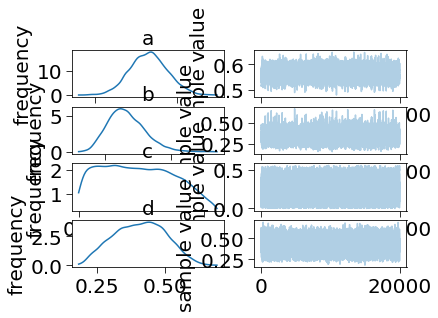

In [96]:
fit.plot()
plt.show()

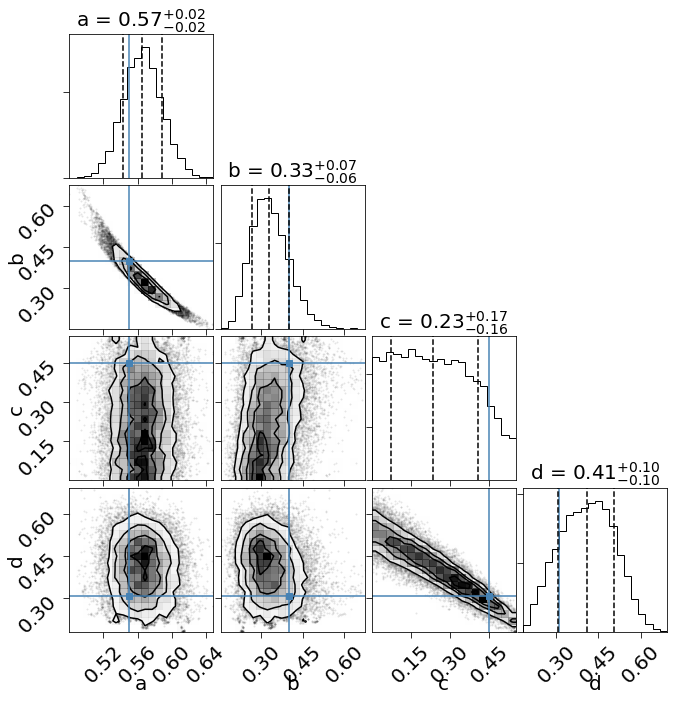

In [97]:
import corner
labels=['a','b','c','d']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, truths=angus,
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

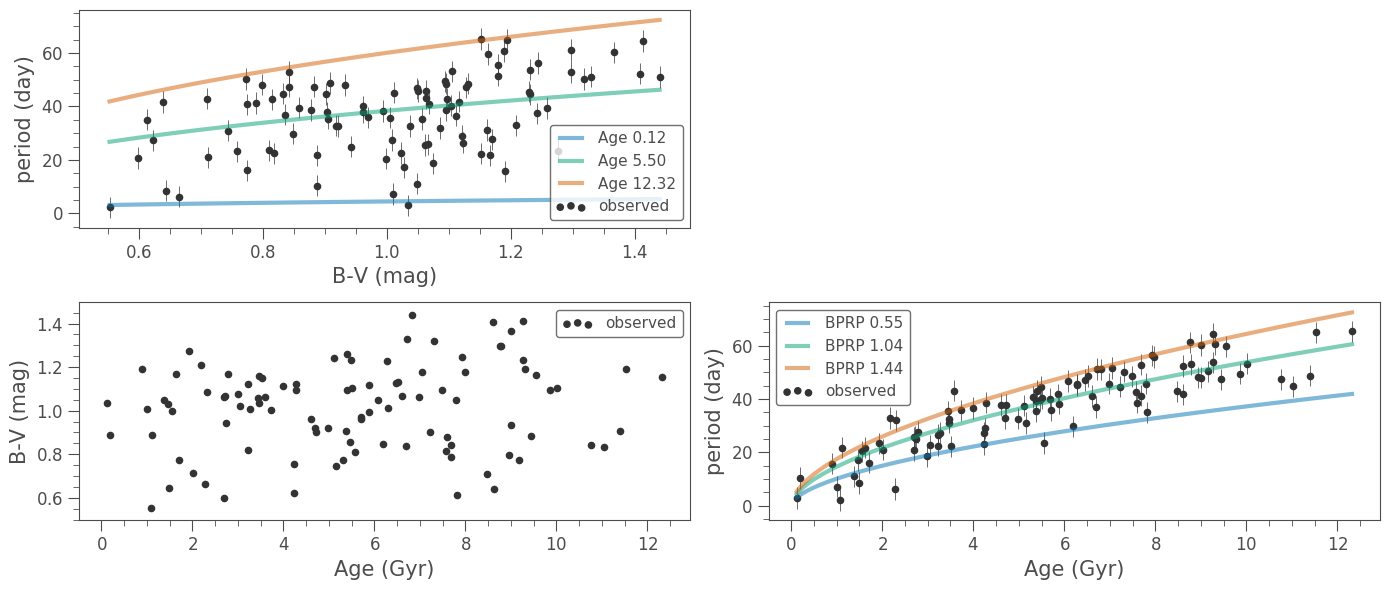

In [98]:
import matplotlib.gridspec as gridspec
import mystyle as ms

gyrores = [np.median(fit[label]) for label in ['a','b','c','d']]

with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
    ax0.scatter(bprp_obs, period_obs,zorder=1, s=20, label='observed')
    ax0.errorbar(bprp_obs, period_obs, yerr=sigma_p, xerr=sigma_bprp, fmt='|',zorder=0)
    ax0.set_xlabel('B-V (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
    ax1.scatter(age_obs, period_obs,zorder=1, s=20, label='observed')
    ax1.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
    ax2.scatter(age_obs, bprp_obs,zorder=1, s=20, label='observed')
    ax2.errorbar(age_obs, bprp_obs, yerr=sigma_bprp, xerr=sigma_age, fmt='|',zorder=0)
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('B-V (mag)')
    ax2.legend()    
    
    agex = np.linspace(age_true.min(), age_true.max(), 100)
    ax1.plot(agex, gyro(agex, bprp_true.min(), *gyrores), label='BPRP {:.2f}'.format(bprp_true.min()), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, np.mean(bprp_true), *gyrores), label='BPRP {:.2f}'.format(np.median(bprp_true)), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, bprp_true.max(), *gyrores), label='BPRP {:.2f}'.format(bprp_true.max()), 
             lw=3, alpha=.5)    
    ax1.legend()
    
    bprpx = np.linspace(bprp_true.min(), bprp_true.max(), 100)
    ax0.plot(bprpx, gyro(age_true.min(), bprpx, *gyrores), label='Age {:.2f}'.format(age_true.min()), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(np.mean(age_true), bprpx, *gyrores), label='Age {:.2f}'.format(np.median(age_true)), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(age_true.max(), bprpx, *gyrores), label='Age {:.2f}'.format(age_true.max()), 
             lw=3, alpha=.5)    
    ax0.legend()    
    
    fig.tight_layout()
    plt.show()